# Clustering_DBSCAN on Amazon reviews dataset

In [1]:
#import libraries.....
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
import time
import datetime
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from pyclustering.cluster.kmedoids import kmedoids
#import kmedoids
from pyclustering.utils import calculate_distance_matrix

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [71]:
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite')

final_tbs=pd.read_sql_query("""select * from Reviews limit 10000""",con) # The table was preprocessed with time based splitting.
con.close()

final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [72]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

print(final_tbs['Score'].value_counts())

final_tbs.head(5)


1    8861
0    1139
Name: Score, dtype: int64


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [73]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


In [74]:
def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1500, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(text) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

In [75]:
def show_features(vectorizer,cluster):
    text =' '
    terms = vectorizer.get_feature_names()
    coefs_with_fns = (zip(cluster, terms))
    #top = coefs_with_fns[:-(n + 1):-1]
    top = coefs_with_fns
    for (coef_1, fn_1) in top:
        text = text + fn_1 + ' '
    plot_wordcloud(text)


### BOW

In [76]:
count_vect = CountVectorizer(min_df=10) #in scikit-learn
final_bows = count_vect.fit_transform(final_tbs['Summary_CleanedText'])

Standard = StandardScaler(with_mean=False)
final_std_bows = Standard.fit_transform(final_bows)

np.shape(final_std_bows)

(10000, 3059)

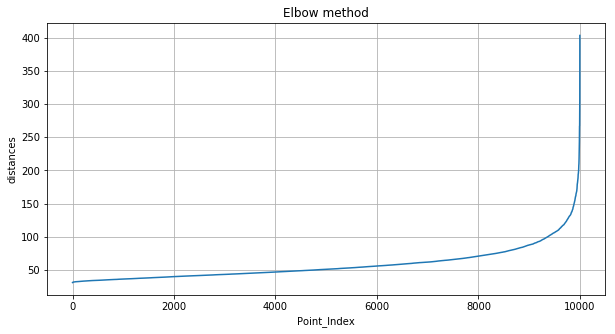

In [77]:
min_points = np.shape(final_std_bows)[1]+100
nbrs = NearestNeighbors(n_neighbors=min_points).fit(final_std_bows)
distances, indices = nbrs.kneighbors(final_std_bows)

dist = list(distances[:,-1])
dist.sort()

plt.figure(figsize=(10,5))
plt.plot(list(range(len(dist))),dist)
plt.xlabel('Point_Index')
plt.ylabel('distances')
plt.title("Elbow method")
plt.grid()
#print(list(range(len(distances))))


In [78]:
dbscan = DBSCAN(eps=125,min_samples=min_points)
dbscan.fit(final_std_bows)
labels_bow_dbscan = dbscan.labels_

In [79]:
cluster_0 = []
cluster_1 = []
for index,lab in enumerate(labels_bow_dbscan):
    if lab == 0:
        cluster_0.append(index)
    if lab == 1:
        cluster_1.append(index)

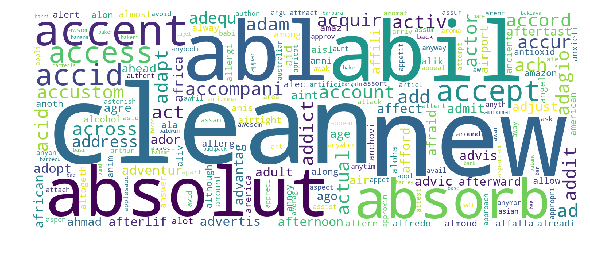

In [80]:
show_features(count_vect,cluster_0)

In [81]:
#show_features(count_vect,cluster_1)

### TFIDF

In [82]:
tf_idf_vect = TfidfVectorizer(min_df=10)

final_std_tfidf = tf_idf_vect.fit_transform(final_tbs['Summary_CleanedText'])

Standard = StandardScaler(with_mean=False)

final_std_tfidf = Standard.fit_transform(final_std_tfidf)

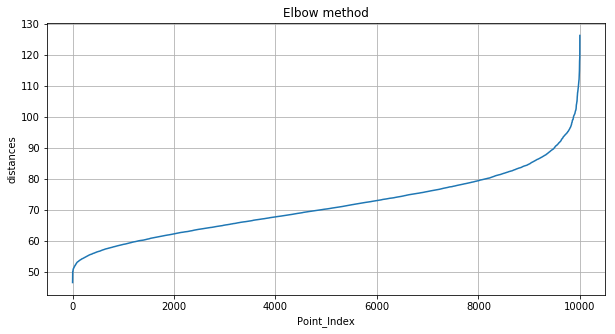

In [83]:
min_points = np.shape(final_std_tfidf)[1]+100
nbrs = NearestNeighbors(n_neighbors=min_points).fit(final_std_tfidf)
distances, indices = nbrs.kneighbors(final_std_tfidf)

dist = list(distances[:,-1])
dist.sort()

plt.figure(figsize=(10,5))
plt.plot(list(range(len(dist))),dist)
plt.xlabel('Point_Index')
plt.ylabel('distances')
plt.title("Elbow method")
plt.grid()
#print(list(range(len(distances))))


In [84]:
dbscan = DBSCAN(eps=75,min_samples=min_points)
dbscan.fit(final_std_tfidf)
labels_tfidf_dbscan = dbscan.labels_

In [85]:
cluster_0 = []
cluster_1 = []
for index,lab in enumerate(labels_tfidf_dbscan):
    if lab == 0:
        cluster_0.append(index)
    if lab == 1:
        cluster_1.append(index)

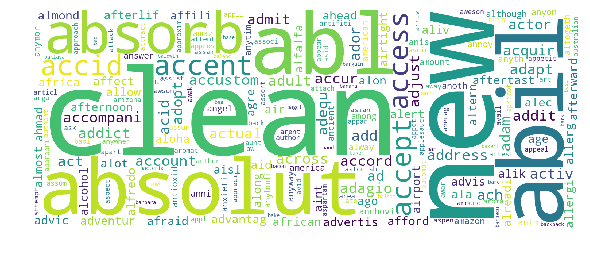

In [86]:
show_features(tf_idf_vect,cluster_0)

In [87]:
#show_features(count_vect,cluster_1)

### W2V

In [88]:
def show_features_w2v(list_words,cluster):
    text =' '
    coefs_with_fns = (zip(cluster, list_words))
    #top = coefs_with_fns[:-(n + 1):-1]
    top = coefs_with_fns
    for (coef_1, fn_1) in top:
        text = text + fn_1 + ' '
    plot_wordcloud(text)


### AVG_W2V

In [89]:
# We have to train Word2Vec only by using train data.
def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=100, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

In [90]:
def avgw2v(list_of_sent,w2v_model,w2v_words):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors


In [91]:
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
#train_sent_vectors=[]
#cv_sent_vectors=[]
#test_sent_vectors=[]

list_of_sent=[]
for sent in final_tbs['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
w2v_model,w2v_words_avg = train_Word2Vec(list_of_sent)
train_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words_avg)
    
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

10000
100
00:00:10


In [92]:
Standard = StandardScaler(with_mean=False)

final_std_avg = Standard.fit_transform(train_sent_vectors)

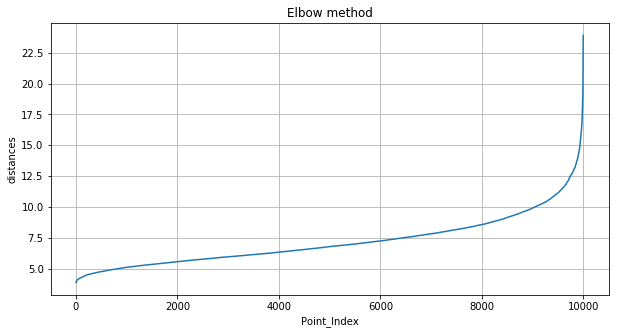

In [93]:
min_points = 200
nbrs = NearestNeighbors(n_neighbors=min_points).fit(final_std_avg)
distances, indices = nbrs.kneighbors(final_std_avg)

dist = list(distances[:,-1])
dist.sort()

plt.figure(figsize=(10,5))
plt.plot(list(range(len(dist))),dist)
plt.xlabel('Point_Index')
plt.ylabel('distances')
plt.title("Elbow method")
plt.grid()
#print(list(range(len(distances))))


In [94]:
dbscan = DBSCAN(eps=7,min_samples=min_points)
dbscan.fit(final_std_avg)
labels_avg_dbscan = dbscan.labels_

In [95]:
cluster_0 = []
cluster_1 = []
for index,lab in enumerate(labels_avg_dbscan):
    if lab == 0:
        cluster_0.append(index)
    if lab == 1:
        cluster_1.append(index)

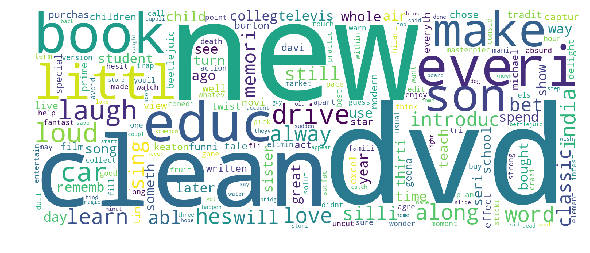

In [96]:
show_features_w2v(w2v_words_avg,cluster_0)

In [97]:
#show_features_w2v(w2v_words_avg,cluster_1)

### TFIDF_W2V

In [98]:
#Only for train data

def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=100, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

def compute_tfidf(list_of_sent,w2v_words,dictionary):
    for sent in list_of_sent:
        for word in sent:
            if word in w2v_words:
                 tf_idf_train_data = dictionary[word]*(sent.count(word)/len(sent)) # Computing tfidf value only with train data.
    return tf_idf_train_data

In [99]:
def tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf):
    # TF-IDF weighted Word2Vec
    #model = TfidfVectorizer()
    #tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(100) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [100]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

model = TfidfVectorizer()
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final_tbs['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
                        
tf_idf_matrix = model.fit_transform(final_tbs['Summary_CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

w2v_model,w2v_words_tfidf = train_Word2Vec(list_of_sent)

tf_idf_train_data = compute_tfidf(list_of_sent,w2v_words_tfidf,dictionary)

train_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words_tfidf,tf_idf_train_data)

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))


00:00:20


In [101]:
Standard = StandardScaler(with_mean=False)

final_std_tfidfw2v = Standard.fit_transform(train_tfidf_w2v_vectors)

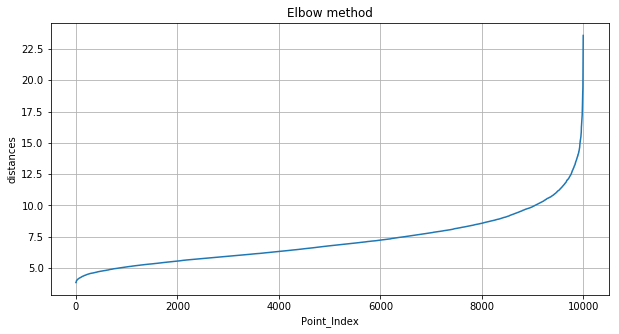

In [102]:
min_points = 200
nbrs = NearestNeighbors(n_neighbors=min_points).fit(final_std_tfidfw2v)
distances, indices = nbrs.kneighbors(final_std_tfidfw2v)

dist = list(distances[:,-1])
dist.sort()

plt.figure(figsize=(10,5))
plt.plot(list(range(len(dist))),dist)
plt.xlabel('Point_Index')
plt.ylabel('distances')
plt.title("Elbow method")
plt.grid()
#print(list(range(len(distances))))


In [103]:
dbscan = DBSCAN(eps=7,min_samples=min_points)
dbscan.fit(final_std_tfidfw2v)
labels_avg_dbscan = dbscan.labels_

In [104]:
cluster_0 = []
cluster_1 = []
for index,lab in enumerate(labels_avg_dbscan):
    if lab == 0:
        cluster_0.append(index)
    if lab == 1:
        cluster_1.append(index)

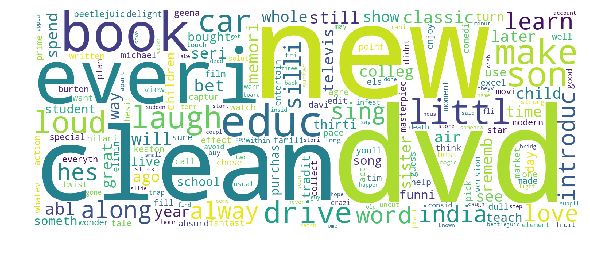

In [105]:
show_features_w2v(w2v_words_tfidf,cluster_0)

In [106]:
#show_features_w2v(w2v_words_tfidf,cluster_1)